In [1]:
from mlchartist.array_builder import full_dataset_randomised_arrays
from mlchartist.preprocessing import train_test_split
from mlchartist.features import transform_file, build_data, save_ticker
from mlchartist.features import proper_name, to_date, proper_col, get_indicators, calculate_past_returns, calculate_real_returns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [2]:
# Reads Nasdaq 100 components

nasdaq100 = pd.read_csv('../../raw_data/nasdaq100.csv', header=None)

In [3]:
nasdaq100_list = list(nasdaq100.values.flatten())

### Generate processed csvs for each company

In [10]:
def transform_current_file(fp):
    df = pd.read_csv(fp)
    df.columns = [proper_name(col) for col in df.columns]
    df['date'] = to_date(df, 'date')
    df = proper_col(df)
    df.drop(columns=['per', 'time', 'openint'], inplace=True)
    df = get_indicators(df)
    df_final = calculate_real_returns(df)
    df_final = calculate_past_returns(df_final)
    df_final = df_final.sort_values(by='date', ascending=False)
    df_final = df_final.head(5000).dropna().drop(columns = ['open', 'high','low','close', 'vol']).reset_index(drop=True)
    return df_final

In [11]:
raw_data_folder = '../../raw_data/data_current/daily/us/nasdaq stocks/'
destination_path='../../raw_data/processed_5000/'
len_hist = 500

In [12]:
files_changed = 0
for subdir, dirs, files in os.walk(raw_data_folder):
    for filename in files:
        if filename[:-7].upper() in nasdaq100_list:
            filepath = subdir + os.sep + filename
            if not subdir.endswith('.ipynb_checkpoints'):
                if filename.endswith('txt'):
                    with open(filepath) as f:
                        rows_num = sum(1 for line in f)
                        if rows_num >= len_hist:
                            df = transform_current_file(filepath)
                            new_name = filename[:-7] + '.csv'
                            targetpath = destination_path + os.sep + new_name
                            save_ticker(df, targetpath)
                            files_changed += 1

/home/kensei/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/home/kensei/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/home/kensei/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/home/kensei/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/home/kensei/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])


### Build train and test sets

In [5]:
ticker_map = {}

for i, ticker in enumerate(sorted(nasdaq100_list)):
    ticker_map[ticker] = i

name_codes = {}

for key, value in ticker_map.items():
    codding_series = pd.Series(list(bin(ticker_map[key])[2:].rjust(7, "0")), index=['name_code_0', 'name_code_1', 'name_code_2', 'name_code_3', 'name_code_4', 'name_code_5', 'name_code_6'])
    name_codes[key] = codding_series

name_codes_df = pd.DataFrame(name_codes).T.reset_index()

name_codes_df

,index,name_code_0,name_code_1,name_code_2,name_code_3,name_code_4,name_code_5,name_code_6
0,AAPL,0,0,0,0,0,0,0
1,ADBE,0,0,0,0,0,0,1
2,ADI,0,0,0,0,0,1,0
3,ADP,0,0,0,0,0,1,1
4,ADSK,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
97,WBA,1,1,0,0,0,0,1
98,WDAY,1,1,0,0,0,1,0
99,XEL,1,1,0,0,0,1,1
100,XLNX,1,1,0,0,1,0,0


In [4]:
joined_df = pd.DataFrame()

# Takes nrows from history from each company from the sample
nrows = 2500

for ticker in nasdaq100_list:
    ticker_path = '../../raw_data/processed/' + ticker.strip().lower() + '.csv'
    ticker_df = pd.read_csv(ticker_path, nrows=nrows)
    if ticker_df.shape[0] > 500:
        joined_df = joined_df.append(ticker_df)
    else:
        print(f'{ticker} has shorter history than 500')
    

ZM has shorter history than 500
MRNA has shorter history than 500
PTON has shorter history than 500
FOXA has shorter history than 500
FOX has shorter history than 500


In [5]:
joined_df['date'] = pd.to_datetime(joined_df['date'])

FIVE_TR = 0.0006
TEN_TR = 0.0012
TWENTY_TR = 0.0024

# Drops 'ADI' and 'OBV' from input columns
# INPUT_COLS = ['RSI', 'Stochastic', 'Stochastic_signal', 'ADI','OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff','MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return']
INPUT_COLS = ['RSI', 'Stochastic', 'Stochastic_signal', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff','MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return']


joined_df['5D_return_bin'] = (joined_df['5TD_return'] >= FIVE_TR)
joined_df['10D_return_bin'] = (joined_df['10TD_return'] >= TEN_TR)
joined_df['20D_return_bin'] = (joined_df['20TD_return'] >= TWENTY_TR)

In [6]:
joined_df_enc = joined_df.merge(name_codes_df, how='left', left_on='ticker', right_on='index').drop(columns='index')

NameError: name 'name_codes_df' is not defined

In [9]:
joined_df_enc.columns

Index(['ticker', 'date', 'RSI', 'Stochastic', 'Stochastic_signal', 'ADI',
       'OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff',
       'MACD_signal', '5TD_return', '10TD_return', '20TD_return',
       '1D_past_return', '5D_past_return', '10D_past_return', '5D_return_bin',
       '10D_return_bin', '20D_return_bin', 'name_code_0', 'name_code_1',
       'name_code_2', 'name_code_3', 'name_code_4', 'name_code_5',
       'name_code_6'],
      dtype='object')

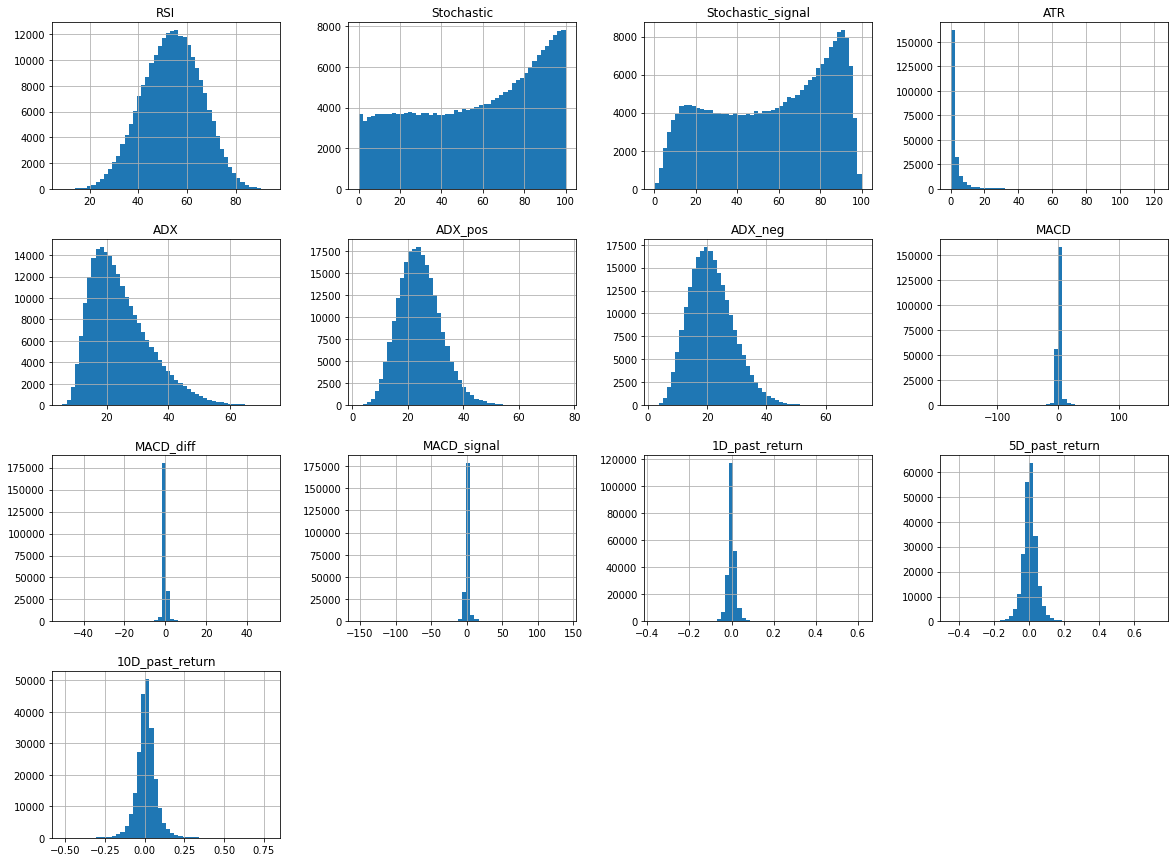

In [7]:
# Plots distribution of the input df without removing outliers
joined_df[INPUT_COLS].hist(figsize=(20, 15), bins=50)
plt.show()

In [8]:
INPUT_COLS_ENC = ['RSI', 'Stochastic', 'Stochastic_signal', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff', 'MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return',
                  'name_code_0', 'name_code_1', 'name_code_2', 'name_code_3', 'name_code_4', 'name_code_5','name_code_6']
TARGET_COLS=['10D_return_bin']
OUTLIER_VALIDATION={'1D_past_return': [-0.2, 0.2]}
STRIDE = 1

train_x, train_y, test_x, test_y, scaler = full_dataset_randomised_arrays(unsplit_df=joined_df,
                                                                          train_df=None,
                                                                          test_df=None,
                                                                          split_dataframe=True,
                                                                          test_set_size=500,
                                                                          time_window=30,
                                                                          stride=STRIDE,
                                                                          verbose=True,
                                                                          fitted_scaler=None,
                                                                          check_train_outliers=True,
                                                                          check_test_outliers=False,
                                                                          outlier_threshold=1,
                                                                          input_cols=INPUT_COLS,
                                                                          target_col=TARGET_COLS,
                                                                          outlier_validation=OUTLIER_VALIDATION)

print('train_x', train_x.shape)
print('train_y', train_y.shape)
print('test_x', test_x.shape)
print('test_y', test_y.shape)
print('scaler', scaler)


Train/Test Split: Splitting unsplit dataframe
Scaler: Fitting scaler on train set
97 Companies in Dataset
Starting AAPL: Company 1 of 97
Starting MSFT: Company 2 of 97
Starting AMZN: Company 3 of 97
Starting TSLA: Company 4 of 97
Starting GOOG: Company 5 of 97
Starting FB: Company 6 of 97
Starting GOOGL: Company 7 of 97
Starting NVDA: Company 8 of 97
Starting PYPL: Company 9 of 97
Starting INTC: Company 10 of 97
Starting NFLX: Company 11 of 97
Starting CMCSA: Company 12 of 97
Starting ADBE: Company 13 of 97
Starting CSCO: Company 14 of 97
Starting AVGO: Company 15 of 97
Starting PEP: Company 16 of 97
Starting QCOM: Company 17 of 97
Starting TXN: Company 18 of 97
Starting COST: Company 19 of 97
Starting TMUS: Company 20 of 97
Starting AMGN: Company 21 of 97
Starting SBUX: Company 22 of 97
Starting CHTR: Company 23 of 97
Starting AMD: Company 24 of 97
Starting INTU: Company 25 of 97
Starting AMAT: Company 26 of 97
Starting MU: Company 27 of 97
Starting MELI: Company 28 of 97
Starting ISR

In [12]:
import joblib

In [13]:
# joblib.dump(train_x, '../../raw_data/train_dump/train_x_2500')
# joblib.dump(train_y, '../../raw_data/train_dump/train_y_2500')
# joblib.dump(test_x, '../../raw_data/train_dump/test_x_2500')
# joblib.dump(test_y, '../../raw_data/train_dump/test_y_2500')
joblib.dump(scaler, '../../raw_data/train_dump/scaler_170k_rows_new')

['../../raw_data/train_dump/scaler_170k_rows_new']

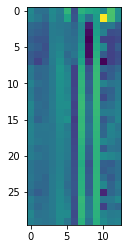

In [26]:
plt.imshow(pd.DataFrame(test_x[100]))

In [15]:
train_x.shape

(175341, 30, 13)

In [16]:
import random

# Samples n rows of train_x

indx = list(range(len(train_x)))
sample_indx = random.sample(indx, 175000)
X_train_sample =  train_x[[sample_indx], :][0]
y_train_sample = train_y[[sample_indx]]

/home/kensei/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [17]:
from tensorflow.keras.metrics import Precision, BinaryAccuracy
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models 
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax


optim = RMSprop(learning_rate=0.0001)
precision = Precision(thresholds=0.8)
bin_accuracy = BinaryAccuracy(threshold=0.8)

def init_model():
    model = Sequential()
    reg_l1 = regularizers.l1(0.001)
    reg_l2 = regularizers.l2(0.001)
    reg_l1_l2 = regularizers.l1_l2(l1=0.001, l2=0.001)
    model.add(layers.LSTM(100, return_sequences=True, input_shape=(30,13), activation='tanh'))
    model.add(layers.Dropout(0.3))
    model.add(layers.LSTM(100, activation='tanh'))
    model.add(layers.Dropout(0.3))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(100, activation='relu', kernel_regularizer=reg_l1))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(50, activation='relu', bias_regularizer=reg_l2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(20, activation='relu', activity_regularizer=reg_l1_l2))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optim, metrics=[precision, bin_accuracy])
    
    return model

In [18]:
model = init_model()

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=10, restore_best_weights=True)
rp = ReduceLROnPlateau(patience=3, verbose=1, min_lr=0.00001)

model.fit(train_x, train_y, 
          epochs=500, 
          batch_size=16,
          validation_split=0.2,
          callbacks=[es, rp])

Epoch 1/500
8767/8767 [==============================] - 82s 9ms/step - loss: 1.0295 - precision: 0.5328 - binary_accuracy: 0.4405 - val_loss: 0.7101 - val_precision: 0.0000e+00 - val_binary_accuracy: 0.4410
Epoch 2/500
8767/8767 [==============================] - 94s 11ms/step - loss: 0.6922 - precision: 0.0000e+00 - binary_accuracy: 0.4404 - val_loss: 0.6882 - val_precision: 0.0000e+00 - val_binary_accuracy: 0.4410
Epoch 3/500
8767/8767 [==============================] - 92s 11ms/step - loss: 0.6881 - precision: 0.0000e+00 - binary_accuracy: 0.4404 - val_loss: 0.6871 - val_precision: 0.0000e+00 - val_binary_accuracy: 0.4410
Epoch 4/500
8767/8767 [==============================] - 92s 10ms/step - loss: 0.6872 - precision: 1.0000 - binary_accuracy: 0.4404 - val_loss: 0.6866 - val_precision: 0.0000e+00 - val_binary_accuracy: 0.4410
Epoch 5/500
8767/8767 [==============================] - 89s 10ms/step - loss: 0.6865 - precision: 0.5455 - binary_accuracy: 0.4404 - val_loss: 0.6863 - val_

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 100)           45600     
_________________________________________________________________
dropout (Dropout)            (None, 30, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0

In [19]:
train_y.sum()/len(train_y)

0.5594926457588356

In [20]:
test_y.sum()/len(test_y)

0.5973471665900585

In [21]:
model.evaluate(test_x, test_y)

1428/1428 [==============================] - 3s 2ms/step - loss: 0.9367 - precision: 0.6015 - binary_accuracy: 0.4530


[0.9366998076438904, 0.6014646291732788, 0.4529953896999359]

In [29]:
model.save('../../models/Nasdaq_100_175k_retrained')

INFO:tensorflow:Assets written to: ../../models/Nasdaq_100_170k_rows_big/assets


In [27]:
from tensorflow.keras.backend import expand_dims
X_cnn_train = expand_dims(train_x, axis=-1)
X_cnn_test = expand_dims(test_x, axis=-1)

In [84]:
def init_cnn():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (5, 1), padding='same', input_shape=(30, 13, 1), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [85]:
del cnn, es, rp

In [86]:
cnn = init_cnn()

cnn.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[precision, bin_accuracy])

es = EarlyStopping(patience=10, restore_best_weights=True)
rp = ReduceLROnPlateau(patience=3, verbose=1, min_lr=0.00001)

cnn.fit(X_cnn_train, train_y, 
          epochs=500, 
          batch_size=16,
          validation_split=0.2,
          callbacks=[es, rp])

Epoch 1/500
8767/8767 [==============================] - 15s 2ms/step - loss: 0.6867 - precision: 0.7744 - binary_accuracy: 0.4501 - val_loss: 0.6864 - val_precision: 0.0000e+00 - val_binary_accuracy: 0.4410
Epoch 2/500
8767/8767 [==============================] - 16s 2ms/step - loss: 0.6858 - precision: 0.5897 - binary_accuracy: 0.4404 - val_loss: 0.6855 - val_precision: 0.0000e+00 - val_binary_accuracy: 0.4410
Epoch 3/500
8767/8767 [==============================] - 15s 2ms/step - loss: 0.6851 - precision: 0.6000 - binary_accuracy: 0.4404 - val_loss: 0.6842 - val_precision: 0.0000e+00 - val_binary_accuracy: 0.4410
Epoch 4/500
8767/8767 [==============================] - 18s 2ms/step - loss: 0.6837 - precision: 0.7069 - binary_accuracy: 0.4406 - val_loss: 0.6831 - val_precision: 1.0000 - val_binary_accuracy: 0.4411
Epoch 5/500
8767/8767 [==============================] - 15s 2ms/step - loss: 0.6823 - precision: 0.6951 - binary_accuracy: 0.4406 - val_loss: 0.6813 - val_precision: 0.000

In [87]:
cnn.evaluate(X_cnn_test, test_y)

1428/1428 [==============================] - 2s 1ms/step - loss: 0.7284 - precision: 0.6316 - binary_accuracy: 0.4166


[0.7284156084060669, 0.6316224932670593, 0.4165736436843872]

In [57]:
cnn.save('../../models/Nasdaq_100_cnn_175k')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../../models/Nasdaq_100_cnn_175k/assets


In [1]:
from tensorflow.keras import models

In [2]:
model_n100 = models.load_model('../../models/Nasdaq_100_150k')

In [4]:
model_n100.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 30, 200)           171200    
_________________________________________________________________
lstm_47 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dropout_69 (Dropout)         (None, 200)               0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 200)               800       
_________________________________________________________________
dense_92 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_70 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 100)             

In [24]:
model_n100.evaluate(test_x, test_y)

1471/1471 [==============================] - 3s 2ms/step - loss: 0.3339 - precision_24: 0.9329 - accuracy: 0.8828


[0.3338858485221863, 0.9329215288162231, 0.8828129768371582]